In [57]:
#1 Data Outline

# ------Price is in Million------

import pandas as pd
import numpy as np

df = pd.read_csv("/content/bundesliga_player.csv", index_col=0)

df = df.drop_duplicates()
df.drop('full_name', axis=1, inplace=True)

df.head(10)

,name,age,height,nationality,place_of_birth,price,max_price,position,shirt_nr,foot,club,contract_expires,joined_club,player_agent,outfitter
0,Manuel Neuer,37,1.93,Germany,Gelsenkirchen,7.0,45.0,Goalkeeper,1,right,Bayern Munich,2024-06-30,2011-07-01,PRO Profil GmbH,adidas
1,Yann Sommer,34,1.83,Switzerland,Morges,5.0,13.0,Goalkeeper,27,right,Bayern Munich,2025-06-30,2023-01-19,Relatives,Puma
2,Sven Ulreich,34,1.92,Germany,Schorndorf,0.9,6.0,Goalkeeper,26,right,Bayern Munich,2024-06-30,2021-07-01,BMS Sportconsulting ...,adidas
3,Johannes Schenk,20,1.91,Germany,Schweinfurt,0.3,0.3,Goalkeeper,35,NaN,Bayern Munich,2024-06-30,2022-07-01,11WINS,NaN
4,Matthijs de Ligt,23,1.89,Netherlands,Leiderdorp,75.0,75.0,Defender - Centre-Back,4,right,Bayern Munich,2027-06-30,2022-07-19,Rafaela Pimenta,adidas
5,Dayot Upamecano,24,1.86,France Guinea-Bissau,Évreux,60.0,60.0,Defender - Centre-Back,2,right,Bayern Munich,2026-06-30,2021-07-05,Unique Sports Group,Nike
6,Lucas Hernández,27,1.84,France Spain,Marseille,50.0,70.0,Defender - Centre-Back,21,left,Bayern Munich,2024-06-30,2019-07-01,Manuel García ...,Nike
7,Alphonso Davies,22,1.85,Canada Liberia,Buduburam,70.0,80.0,Defender - Left-Back,19,left,Bayern Munich,2025-06-30,2019-01-01,ATG Sports,NaN
8,Daley Blind,33,1.80,Netherlands,Amsterdam,6.0,25.0,Defender - Left-Back,23,left,Bayern Munich,2023-06-30,2023-01-05,SEG,adidas
9,João Cancelo,28,1.82,Portugal,Barreiro,60.0,70.0,Defender - Right-Back,22,right,Bayern Munich,2023-06-30,2023-01-31,Gestifute,Nike


Data Shape (515, 15)

Summary Statistics:
               age      height       price   max_price    shirt_nr
count  515.000000  515.000000  510.000000  510.000000  515.000000
mean    25.683495    1.847612    8.482794   13.513627   19.798058
std      4.700238    0.060996   14.653440   18.659222   12.414768
min     17.000000    1.680000    0.025000    0.100000    1.000000
25%     22.000000    1.800000    1.200000    2.500000    9.000000
50%     25.000000    1.850000    3.500000    7.000000   20.000000
75%     29.000000    1.890000    9.000000   16.750000   29.000000
max     39.000000    2.000000  120.000000  150.000000   49.000000


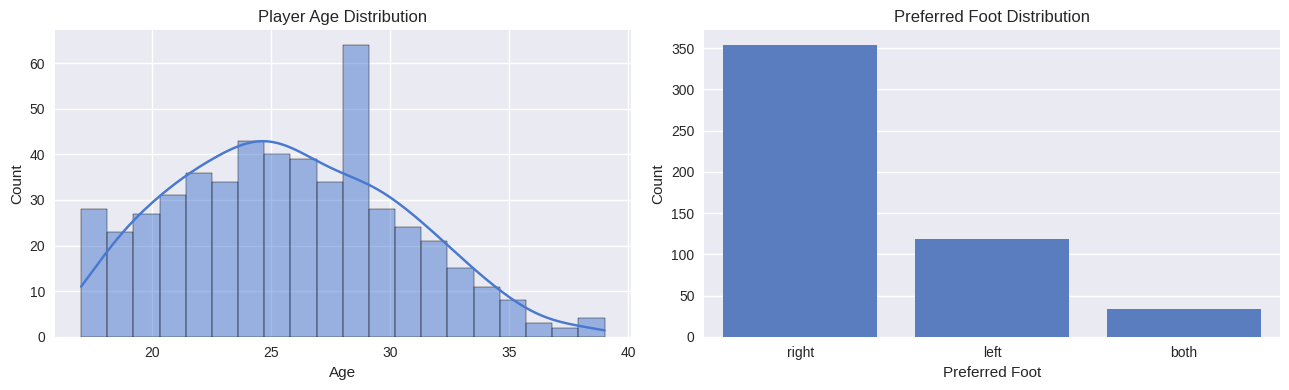

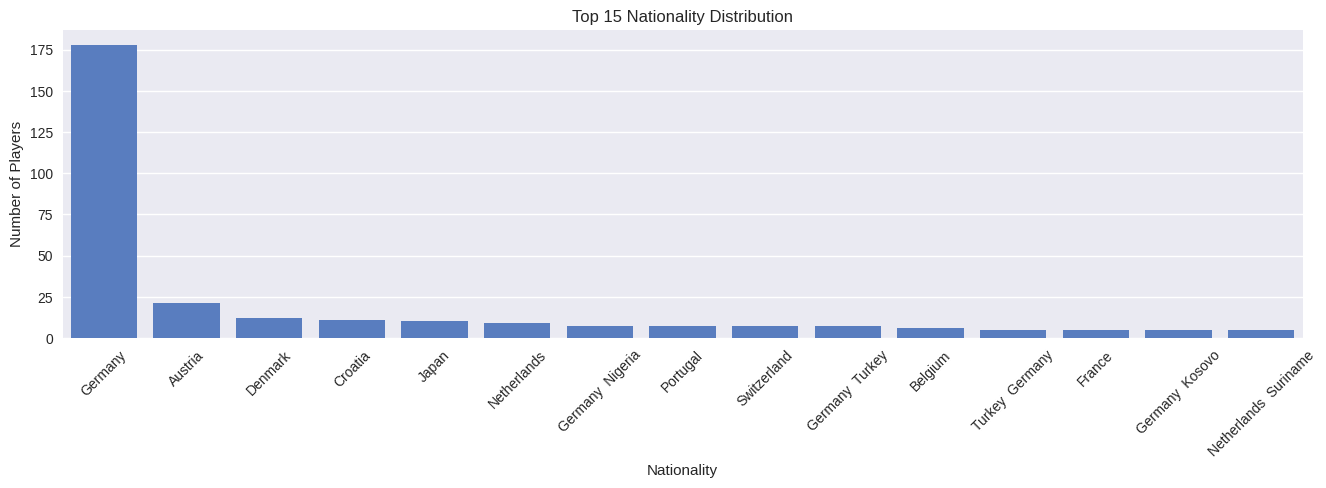

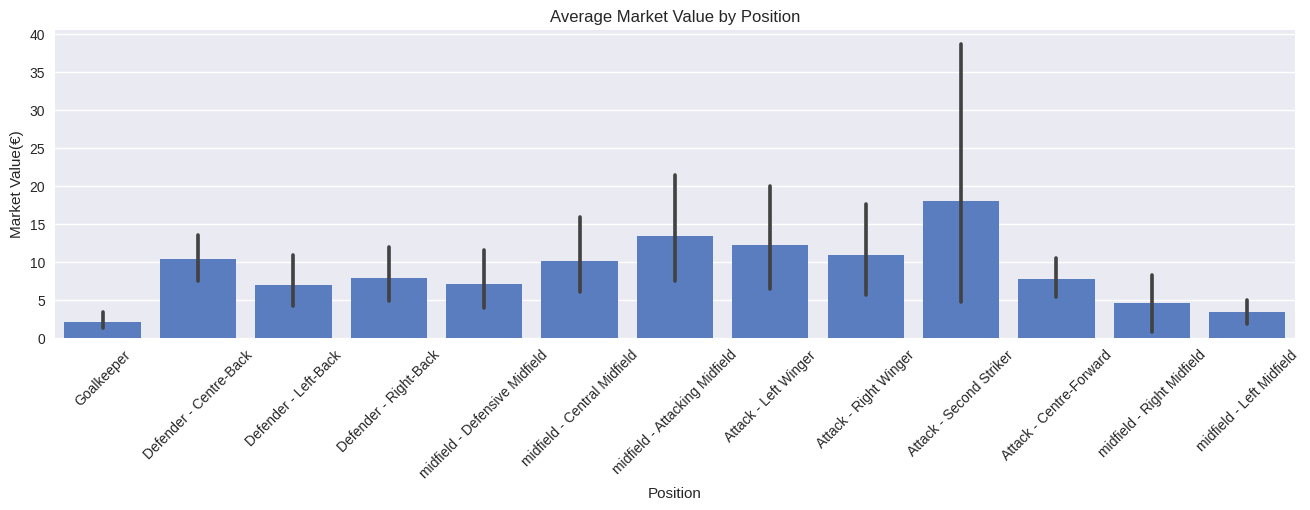

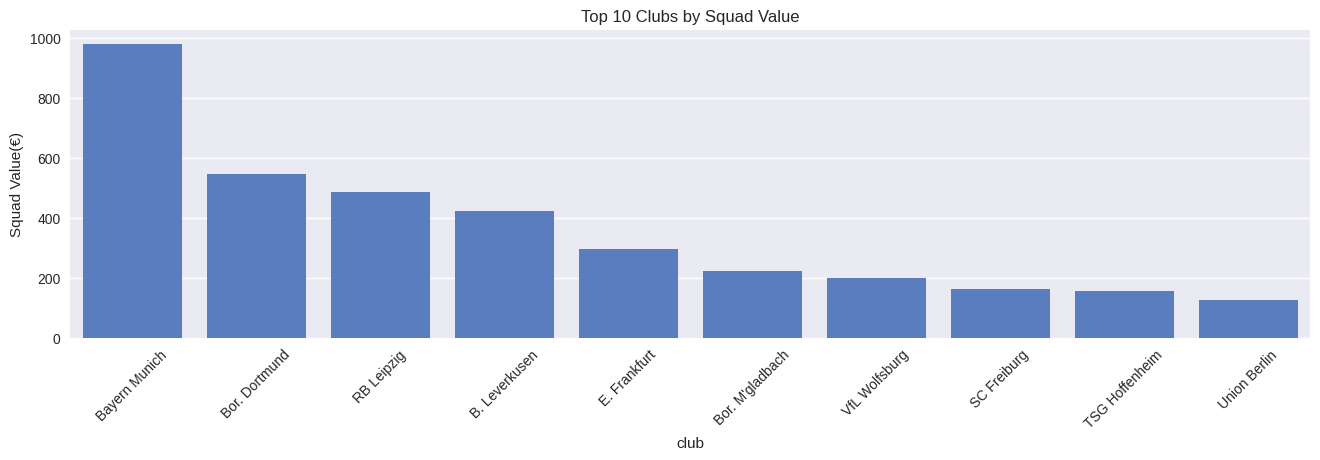

In [44]:
#2 Data Visualization

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set_palette("muted")

# Data Overview
print("Data Shape", df.shape)
print("\nSummary Statistics:\n", df.describe())

fig, axes = plt.subplots(1,2, figsize=(13,4))

# Age Distribution
sns.histplot(df["age"], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Player Age Distribution")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")

#Preferred Foot Distribution
sns.countplot(x="foot", data=df, ax=axes[1])
axes[1].set_title("Preferred Foot Distribution")
axes[1].set_xlabel("Preferred Foot")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

# Nationality Distribution (Top 15)
top_nations = df["nationality"].value_counts().head(15)
plt.figure(figsize=(16,4))
sns.barplot(x=top_nations.index, y=top_nations.values)
plt.title("Top 15 Nationality Distribution")
plt.ylabel("Number of Players")
plt.xlabel("Nationality")
plt.xticks(rotation=45)
plt.show()

# Average Market Value by Position
plt.figure(figsize=(16,4))
sns.barplot(x="position", y="price", data=df)
plt.title("Average Market Value by Position")
plt.ylabel("Market Value(€)")
plt.xlabel("Position")
plt.xticks(rotation=45)
plt.show()

# Top 10 Clubs by Squad Value
club_values = df.groupby("club")["price"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(16,4))
sns.barplot(x=club_values.index, y=club_values.values)
plt.title("Top 10 Clubs by Squad Value")
plt.ylabel("Squad Value(€)")
plt.xticks(rotation=45)
plt.show()

RMSE: €10
R²: 0.426


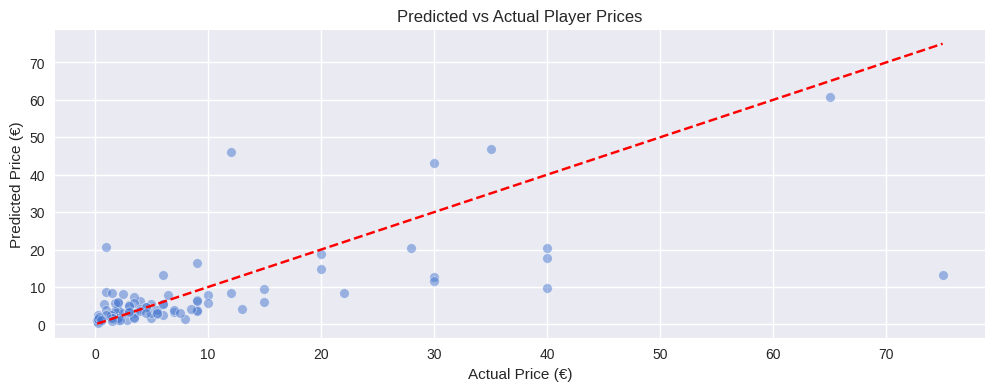

In [45]:
#3 ML Pipeline for Market Value Prediction

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting Features and Target
df['contract_expires'] = pd.to_datetime(df['contract_expires'], errors='coerce')
df['joined_club'] = pd.to_datetime(df['joined_club'], errors='coerce')
df['contract_length'] = (df['contract_expires'] - df['joined_club']).dt.days

features = ['age', 'height', 'position', 'foot', 'club', 'contract_length']
target = 'price'

df_model = df[features + [target]].dropna()
X = df_model[features]
Y = df_model[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = ['age', 'height', 'contract_length']
categorical_features = ['position', 'foot', 'club']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Pipeline with Random Forest
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Log-transform target
Y_train_log = np.log1p(Y_train)
Y_test_log = np.log1p(Y_test)

# Hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [200, 400, 600],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None]
}

search = RandomizedSearchCV(model, param_grid, n_iter=20, cv=3, scoring='r2', n_jobs=-1, random_state=42)
search.fit(X_train, Y_train_log)
best_model = search.best_estimator_

#Handling Outliers (IQR)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df_clean = df[((df['price'] >= (Q1 - 1.5 * IQR)) & (df['price'] <= (Q3 + 1.5 * IQR)))]

# Prediction & Evaluation
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
print(f"RMSE: €{rmse:,.0f}")
print(f"R²: {r2:.3f}")

# Visualization: Predicted vs Actual
plt.figure(figsize=(12,4))
sns.scatterplot(x=Y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Predicted vs Actual Player Prices")
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.show()


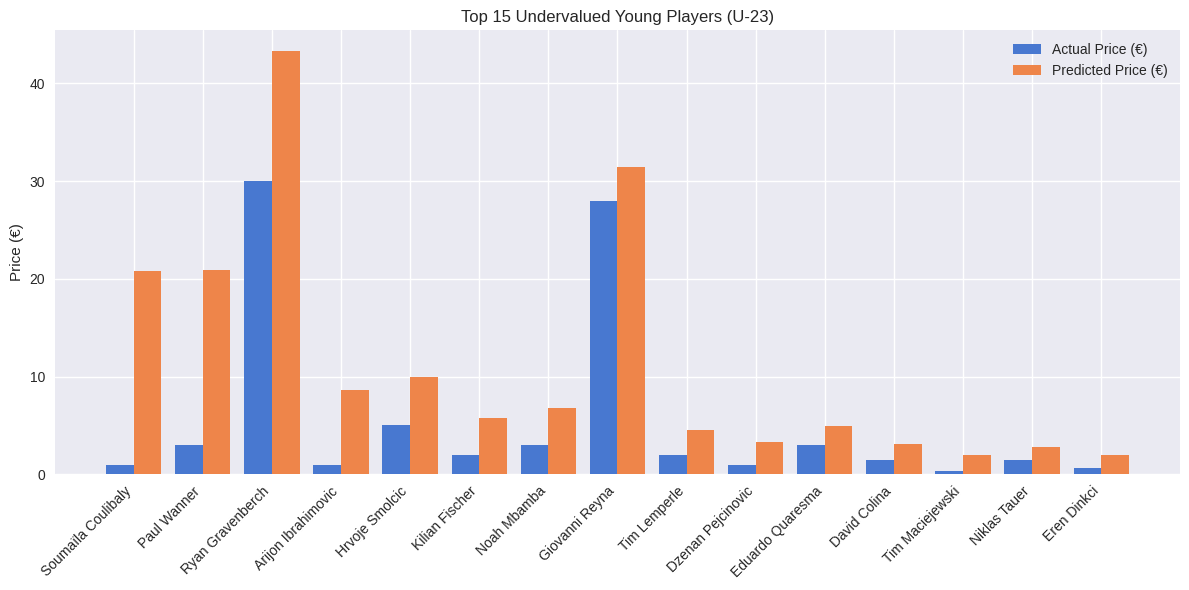

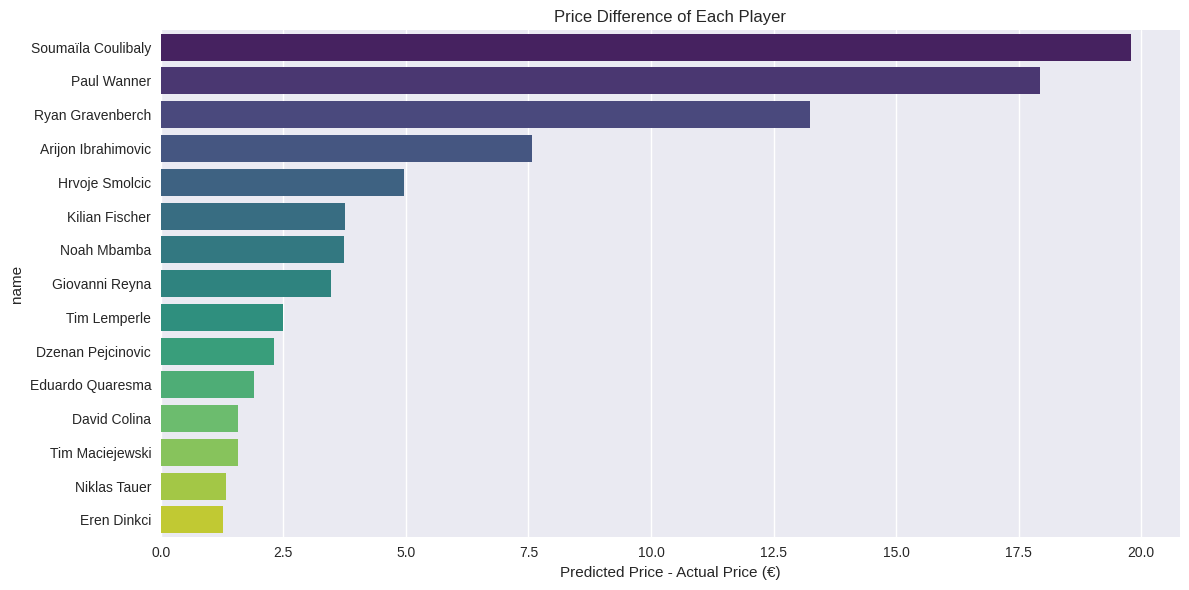

In [56]:
# 4 Finding Undervalued Young Players (U-23)
young_players_idx = df_model[df_model['age'] < 23].index
df_young = df.loc[young_players_idx, ['name', 'age', 'position', 'club', 'price']].copy()

y_pred_young_log = best_model.predict(X.loc[young_players_idx])
df_young['predicted_price'] = np.expm1(y_pred_young_log)

df_young['price_diff'] = df_young['predicted_price'] - df_young['price']

undervalued_young = df_young.sort_values(by='price_diff', ascending=False).head(15)

#Visualization: Undervalued young Players
plt.figure(figsize = (12,6))
players = undervalued_young['name']

x = range(len(players))
plt.bar(x, undervalued_young['price'], width=0.4, label='Actual Price (€)', align='center')
plt.bar([i + 0.4 for i in x], undervalued_young['predicted_price'], width=0.4, label='Predicted Price (€)', align='center')

plt.xticks([i + 0.2 for i in x], players, rotation=45, ha='right')
plt.ylabel('Price (€)')
plt.title("Top 15 Undervalued Young Players (U-23)")
plt.legend()
plt.tight_layout()
plt.show()

#Visualization: Predicted Price - Actual Price
plt.figure(figsize=(12,6))
sns.barplot(
    x='price_diff',
    y='name',
    data=undervalued_young,
    hue='name',
    palette='viridis',
    dodge = False,
    legend=False

)
plt.title("Price Difference of Each Player")
plt.xlabel("Predicted Price - Actual Price (€)")
plt.tight_layout()
plt.show()